In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/league-of-legends-diamond-ranked-games-10-min/high_diamond_ranked_10min.csv


In [2]:
hdr10 = pd.read_csv(os.path.join(dirname, filename))

In [3]:
hdr10.columns = hdr10.columns.str.lower()
hdr10.head()

,gameid,bluewins,bluewardsplaced,bluewardsdestroyed,bluefirstblood,bluekills,bluedeaths,blueassists,blueelitemonsters,bluedragons,...,redtowersdestroyed,redtotalgold,redavglevel,redtotalexperience,redtotalminionskilled,redtotaljungleminionskilled,redgolddiff,redexperiencediff,redcspermin,redgoldpermin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [4]:
hdr10.set_index('gameid',inplace=True)

In [5]:
features = hdr10.columns
features = features[1:]
hdr10_scaled = hdr10[features]

In [6]:
hdr10_scaled.head()

,bluewardsplaced,bluewardsdestroyed,bluefirstblood,bluekills,bluedeaths,blueassists,blueelitemonsters,bluedragons,blueheralds,bluetowersdestroyed,...,redtowersdestroyed,redtotalgold,redavglevel,redtotalexperience,redtotalminionskilled,redtotaljungleminionskilled,redgolddiff,redexperiencediff,redcspermin,redgoldpermin
gameid,,,,,,,,,,,,,,,,,,,,,
4519157822,28,2,1,9,6,11,0,0,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
4523371949,12,1,0,5,5,5,0,0,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
4521474530,15,0,0,7,11,4,1,1,0,0,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
4524384067,43,1,0,4,5,5,1,0,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4436033771,75,4,0,6,6,6,0,0,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [7]:
# Create the scaler with object range of 0-1
scaler = MinMaxScaler()

# Fit and transform using the training data
hdr10_scaled[hdr10_scaled.columns] = scaler.fit_transform(hdr10_scaled[hdr10_scaled.columns])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [8]:
hdr10_scaled.head()

,bluewardsplaced,bluewardsdestroyed,bluefirstblood,bluekills,bluedeaths,blueassists,blueelitemonsters,bluedragons,blueheralds,bluetowersdestroyed,...,redtowersdestroyed,redtotalgold,redavglevel,redtotalexperience,redtotalminionskilled,redtotaljungleminionskilled,redgolddiff,redexperiencediff,redcspermin,redgoldpermin
gameid,,,,,,,,,,,,,,,,,,,,,
4519157822,0.093878,0.074074,1.0,0.409091,0.272727,0.379310,0.0,0.0,0.0,0.0,...,0.0,0.464844,0.588235,0.557608,0.494505,0.579545,0.485446,0.472598,0.494505,0.464844
4523371949,0.028571,0.037037,0.0,0.227273,0.227273,0.172414,0.0,0.0,0.0,0.0,...,0.5,0.556250,0.588235,0.590732,0.730769,0.545455,0.644706,0.538488,0.730769,0.556250
4521474530,0.040816,0.000000,0.0,0.318182,0.500000,0.137931,0.5,1.0,0.0,0.0,...,0.0,0.527170,0.588235,0.575144,0.527473,0.272727,0.566848,0.530570,0.527473,0.527170
4524384067,0.155102,0.037037,0.0,0.181818,0.227273,0.172414,0.5,0.0,1.0,0.0,...,0.0,0.457118,0.647059,0.635039,0.703297,0.488636,0.573530,0.472541,0.703297,0.457118
4436033771,0.285714,0.148148,0.0,0.272727,0.272727,0.206897,0.0,0.0,0.0,0.0,...,0.0,0.537500,0.647059,0.664859,0.648352,0.715909,0.559313,0.459137,0.648352,0.537500


In [9]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(hdr10_scaled, 
                                                              hdr10["bluewins"], 
                                                              test_size=0.2, 
                                                              random_state=20)

# Perform the second split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_temp, y_train_temp, 
                                                      test_size=0.25, random_state=20)

In [10]:
X_train.head()

,bluewardsplaced,bluewardsdestroyed,bluefirstblood,bluekills,bluedeaths,blueassists,blueelitemonsters,bluedragons,blueheralds,bluetowersdestroyed,...,redtowersdestroyed,redtotalgold,redavglevel,redtotalexperience,redtotalminionskilled,redtotaljungleminionskilled,redgolddiff,redexperiencediff,redcspermin,redgoldpermin
gameid,,,,,,,,,,,,,,,,,,,,,
4449308789,0.040816,0.037037,0.0,0.181818,0.409091,0.068966,0.5,1.0,0.0,0.0,...,0.0,0.537066,0.705882,0.727381,0.609890,0.250000,0.611562,0.564335,0.609890,0.537066
4474824262,0.097959,0.000000,1.0,0.227273,0.181818,0.137931,0.0,0.0,0.0,0.0,...,0.0,0.425521,0.647059,0.660115,0.620879,0.647727,0.531506,0.551779,0.620879,0.425521
4517507679,0.330612,0.037037,0.0,0.272727,0.500000,0.172414,0.0,0.0,0.0,0.0,...,0.0,0.669358,0.705882,0.759573,0.664835,0.409091,0.680630,0.564617,0.664835,0.669358
4523127328,0.032653,0.148148,0.0,0.181818,0.318182,0.103448,0.0,0.0,0.0,0.0,...,0.5,0.665885,0.823529,0.812945,0.703297,0.852273,0.741176,0.768904,0.703297,0.665885
4523035934,0.048980,0.148148,0.0,0.272727,0.272727,0.206897,0.0,0.0,0.0,0.0,...,0.0,0.473264,0.588235,0.662657,0.505495,0.727273,0.502085,0.451841,0.505495,0.473264


In [11]:
# Create the scaler with object range of 0-1
#scaler = MinMaxScaler()

# Fit and transform using the training data
#X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])

# Transform the validation and test features
#X_valid[X_valid.columns] = scaler.transform(X_valid[X_valid.columns])
#X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

In [12]:
X_valid.head()

,bluewardsplaced,bluewardsdestroyed,bluefirstblood,bluekills,bluedeaths,blueassists,blueelitemonsters,bluedragons,blueheralds,bluetowersdestroyed,...,redtowersdestroyed,redtotalgold,redavglevel,redtotalexperience,redtotalminionskilled,redtotaljungleminionskilled,redgolddiff,redexperiencediff,redcspermin,redgoldpermin
gameid,,,,,,,,,,,,,,,,,,,,,
4525929245,0.036735,0.000000,0.0,0.090909,0.227273,0.068966,0.5,0.0,1.0,0.0,...,0.0,0.417708,0.647059,0.655286,0.670330,0.545455,0.599901,0.544652,0.670330,0.417708
4470307479,0.053061,0.074074,1.0,0.227273,0.181818,0.137931,0.0,0.0,0.0,0.0,...,0.0,0.333247,0.588235,0.587343,0.428571,0.511364,0.478764,0.507324,0.428571,0.333247
4516132532,0.036735,0.037037,1.0,0.227273,0.090909,0.103448,0.0,0.0,0.0,0.0,...,0.0,0.278299,0.647059,0.631057,0.664835,0.500000,0.417859,0.445280,0.664835,0.278299
4525318009,0.036735,0.000000,0.0,0.181818,0.136364,0.172414,0.0,0.0,0.0,0.0,...,0.0,0.374653,0.588235,0.659607,0.571429,0.590909,0.512490,0.513489,0.571429,0.374653
4496533687,0.036735,0.148148,0.0,0.181818,0.363636,0.103448,0.5,1.0,0.0,0.0,...,0.0,0.514323,0.705882,0.683751,0.730769,0.488636,0.607929,0.521351,0.730769,0.514323


Text(0, 0.5, 'Coefficients')

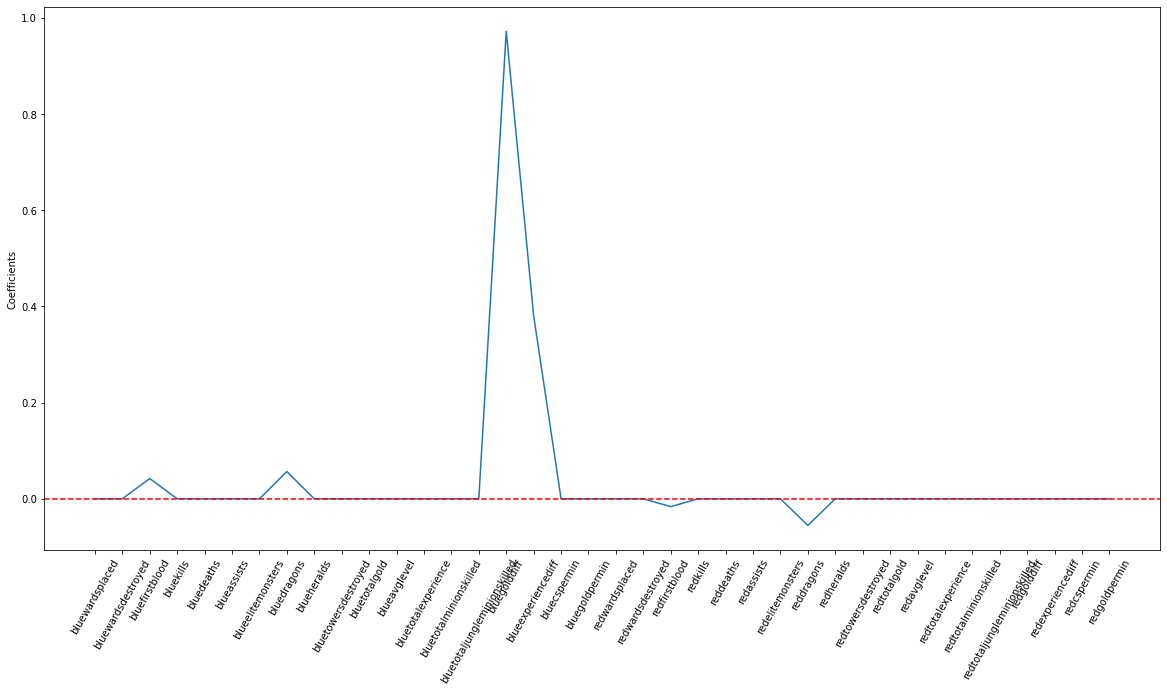

In [13]:
# Create the model
lasso = Lasso(alpha=0.01)

# Fit the model to the training data
lasso.fit(X_train, y_train)

# Extract the coefficients
lasso_coef = lasso.coef_

# Plot the coefficients
plt.figure(figsize=(20, 10))
plt.plot(range(len(X_train.columns)), lasso_coef)
plt.xticks(range(len(X_train.columns)), X_train.columns, rotation=60)
plt.axhline(0.0, linestyle='--', color='r')
plt.ylabel('Coefficients')

In [14]:
X_train_temp = X_train_temp[["bluewins","bluetotalgold","bluegolddiff","redgolddiff","redexperiencediff"]]
X_train = X_train[["bluewins","bluetotalgold","bluegolddiff","redgolddiff","redexperiencediff"]]
X_valid = X_valid[["bluewins","bluetotalgold","bluegolddiff","redgolddiff","redexperiencediff"]]
X_test = X_test[["bluewins","bluetotalgold","bluegolddiff","redgolddiff","redexperiencediff"]]

KeyError: "['bluewins'] not in index"

In [15]:
X_train.head()

,bluewardsplaced,bluewardsdestroyed,bluefirstblood,bluekills,bluedeaths,blueassists,blueelitemonsters,bluedragons,blueheralds,bluetowersdestroyed,...,redtowersdestroyed,redtotalgold,redavglevel,redtotalexperience,redtotalminionskilled,redtotaljungleminionskilled,redgolddiff,redexperiencediff,redcspermin,redgoldpermin
gameid,,,,,,,,,,,,,,,,,,,,,
4449308789,0.040816,0.037037,0.0,0.181818,0.409091,0.068966,0.5,1.0,0.0,0.0,...,0.0,0.537066,0.705882,0.727381,0.609890,0.250000,0.611562,0.564335,0.609890,0.537066
4474824262,0.097959,0.000000,1.0,0.227273,0.181818,0.137931,0.0,0.0,0.0,0.0,...,0.0,0.425521,0.647059,0.660115,0.620879,0.647727,0.531506,0.551779,0.620879,0.425521
4517507679,0.330612,0.037037,0.0,0.272727,0.500000,0.172414,0.0,0.0,0.0,0.0,...,0.0,0.669358,0.705882,0.759573,0.664835,0.409091,0.680630,0.564617,0.664835,0.669358
4523127328,0.032653,0.148148,0.0,0.181818,0.318182,0.103448,0.0,0.0,0.0,0.0,...,0.5,0.665885,0.823529,0.812945,0.703297,0.852273,0.741176,0.768904,0.703297,0.665885
4523035934,0.048980,0.148148,0.0,0.272727,0.272727,0.206897,0.0,0.0,0.0,0.0,...,0.0,0.473264,0.588235,0.662657,0.505495,0.727273,0.502085,0.451841,0.505495,0.473264
